In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
pretrained_model = tf.keras.applications.Xception(include_top=True, weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.xception.decode_predictions

In [4]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (299, 299))
    image = tf.keras.applications.xception.preprocess_input(image)
    image = image[None, ...]
    return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

1/1 [==============================] - 0s 354ms/step


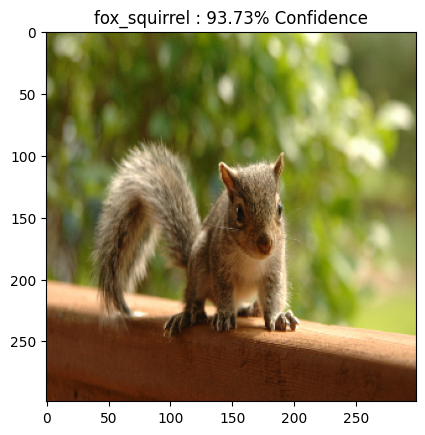

In [263]:
image_path = '/content/drive/MyDrive/test/squirrel1.jpg'
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [264]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

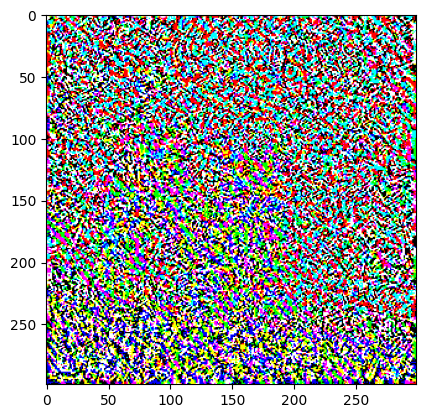

In [265]:
index = 335
label = tf.one_hot(index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);

In [266]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 353ms/step


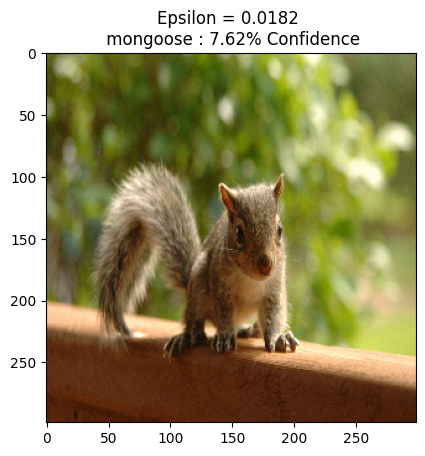

In [269]:
epsilons = [0.0182]
descriptions = [('Epsilon = {:0.4f}'.format(eps) if eps else 'Input')
                for eps in epsilons]


# Display adversarial images using Xception model
for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    tf.keras.preprocessing.image.save_img('{}.jpg'.format(eps), adv_x[0])
    display_images(adv_x, descriptions[i])